## Przygotowanie


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

keras = tf.keras

In [80]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)
  
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()


#Szereg czasowy
Szeregiem czasowym nazywamy uporządkowaną sekwencję, w której dane ułożone są sekwencyjnie, a kluczem określającym ich położenie jest czas.
W zależności od wartości określanych przez encjęw danym punkcie w czasie, dane możemy podzielić na:
- jednowymiarowe (jedna wartość w jednym punkcie)
- wielowymiarowe (wiele wartości w jednym punkcie)

#Występowanie
Szeregi czasowe występują dosłownie w każdej dziedzinie życia. Ich zastosowanie można łatwo dostrzec m.in w prognozach pogody, na giełdzie, w historycznych danych, pomiarach.



#Przykładowy zbiór danych jednowymiarowych.
W tym notatniku pokażemy metody predykcji szeregów czasowych na przykładzie szeregów jednowymiarowych. Przykładowy szereg przedstawiający ilość sprzedanych szamponów na przestrzeni 3 lat

In [16]:
url = "https://raw.githubusercontent.com/Mervolt/TimeSeriesTutorial/master/shampoo.csv"

shampoo_dataset = pd.read_csv(url, error_bad_lines=False)
print(shampoo_dataset)

   Month  Sales
0   1-01  266.0
1   1-02  145.9
2   1-03  183.1
3   1-04  119.3
4   1-05  180.3
5   1-06  168.5
6   1-07  231.8
7   1-08  224.5
8   1-09  192.8
9   1-10  122.9
10  1-11  336.5
11  1-12  185.9
12  2-01  194.3
13  2-02  149.5
14  2-03  210.1
15  2-04  273.3
16  2-05  191.4
17  2-06  287.0
18  2-07  226.0
19  2-08  303.6
20  2-09  289.9
21  2-10  421.6
22  2-11  264.5
23  2-12  342.3
24  3-01  339.7
25  3-02  440.4
26  3-03  315.9
27  3-04  439.3
28  3-05  401.3
29  3-06  437.4
30  3-07  575.5
31  3-08  407.6
32  3-09  682.0
33  3-10  475.3
34  3-11  581.3
35  3-12  646.9


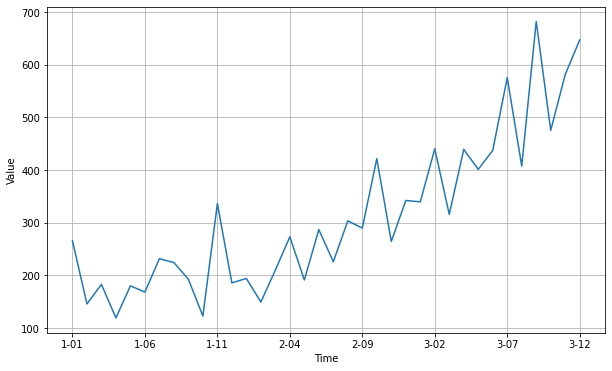

In [17]:
time, values = shampoo_dataset["Month"], shampoo_dataset["Sales"]

plt.figure(figsize=(10, 6))
plot_series(time, values, label = False)
plt.show()

#Wspólne cechy szeregów

Wiele szeregów czasowych posiada takie właściwości jak:
- trend (np. monotoniczny wzrost lub spadek)

- sezonowość, którą można zaobserwować jako okres na wykresie (np. ilość turystów w zależności od miesiąca pokazywać będzie największe wartości w okresie letnim)
- szum, czyli zakłócenia, drobne błędy wartości występujące w zbiorze danych

#Trend rosnący

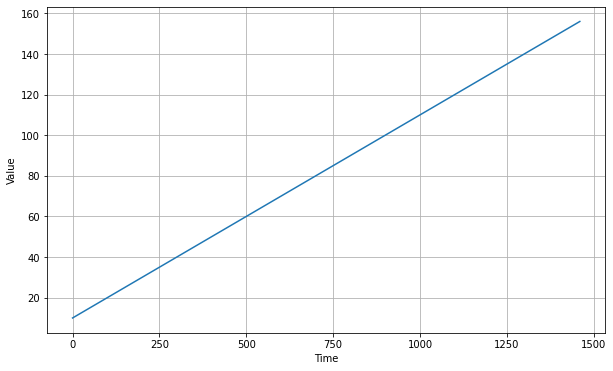

In [18]:
def trend(time, slope=0):
    return slope * time

time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

#Sezonowość

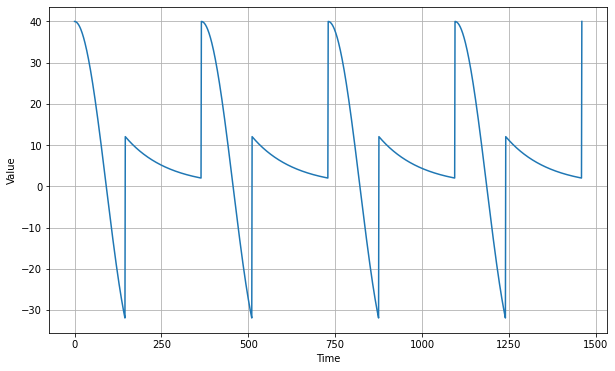

In [19]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

#Szum

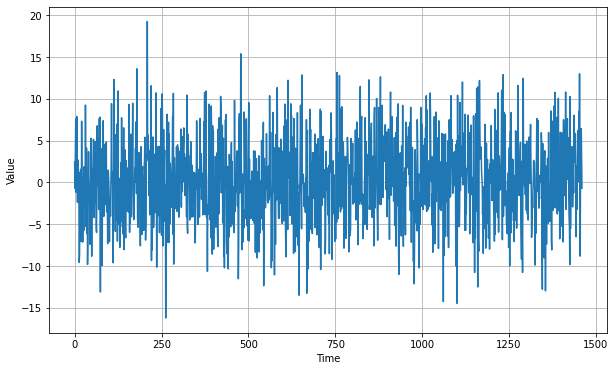

In [20]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

#Przewidywanie

Posiadając zbiór przedstawiający szereg czasowy pewnych wartości możemy zabrać się za próby oszacowania wartości jakie wystąpią w przyszłości.

Użyjemy zbioru przedstawiającego minimalne temperature w Melbourne w latach 1981-1990.

Zbiór podzielimy zgodnie z metodą "Fixed partitioning" na część do uczenia, walidacyjną i testującą.

#Naiwne przewidywanie

Najprostszym możliwym sposobem jest po prostu branie poprzedniej wartości jako przewidywaną. Metoda wydaje się być prymitywna, ale osiągane przez nią rezultaty są warte zaobserwowania chociażby dla celów porównania z innymi metodami.



In [21]:
url = "https://raw.githubusercontent.com/Mervolt/TimeSeriesTutorial/master/melbourne_min_temp.csv"

dataset = pd.read_csv(url)
print(dataset)

            Date  Temp
0     1981-01-01  20.7
1     1981-01-02  17.9
2     1981-01-03  18.8
3     1981-01-04  14.6
4     1981-01-05  15.8
...          ...   ...
3645  1990-12-27  14.0
3646  1990-12-28  13.6
3647  1990-12-29  13.5
3648  1990-12-30  15.7
3649  1990-12-31  13.0

[3650 rows x 2 columns]


In [22]:
split = 3000
time, values = dataset["Date"], dataset["Temp"]
x_train, y_train = time[:split], values[:split]
x_valid, y_valid = time[split:], values[split:] 

In [23]:
naive_forecast = values[split - 1:-1]

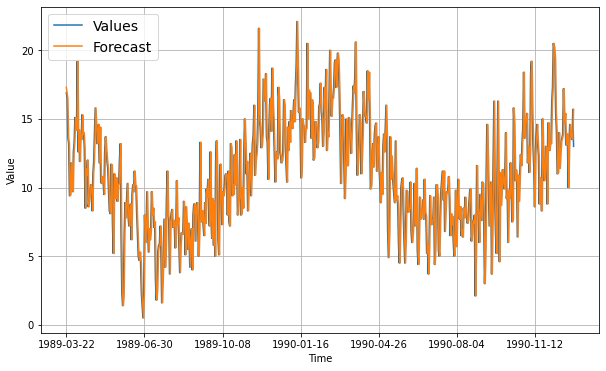

In [24]:
plt.figure(figsize=(10, 6))
plot_series(x_valid, y_valid, label="Values")
plot_series(x_valid, naive_forecast, label="Forecast")

Wykresy nachodzą na siebie w takim stopniu, że nie można ich od siebie odróżnić. Wydzielimy teraz dla celów demonstracyjnych podzbiór.

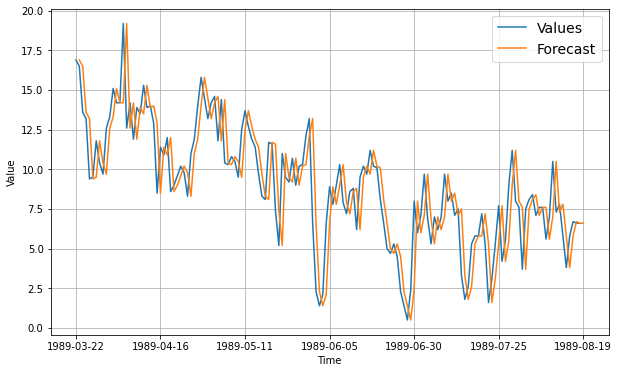

In [25]:
plt.figure(figsize=(10, 6))
plot_series(x_valid, y_valid, start=0, end=150, label="Values")
plot_series(x_valid, naive_forecast, start=1, end=151, label="Forecast")

Możemy zaobserwować, że przewidywania są po prostu 1 krok za rzeczywistymi wartościami.

W celu ewaluacji potrzebujemy metryk. Użyjemy w tym przypadku metryk średniokwadratowej oraz odległości w przestrzeni Euklidesowej.

In [26]:
print(keras.metrics.mean_absolute_error(y_valid, naive_forecast).numpy())
print(keras.metrics.mean_squared_error(y_valid, naive_forecast).numpy())


1.9816923076923076
6.3557384615384604


#Ruchoma średnia
Podejściem, które teraz zostanie zaprezentowane to ruchoma średnia. Jest ono relatywnie proste i polega na wyciąganiu średniej z okresu o długości n. To "ruchome okno" o długości n przesuwamy po całym zbiorze danych.
Przykładowo dla okna o długości, wartość pola o indeksie 7 liczymy jako średnią z pól o indeksach 5, 6 i 7, a dla pola o indeksie 22 z pól o indeksach 20, 21 i 22.

Zalety:
- redukuje szum

Wady:
- nie uwzględnia sezonowości
- nie uwzględnia trendów

In [27]:
def moving_average_forecast(values, window_size):
  forecast = []
  for time in range(len(values) - window_size):
    forecast.append(values[time:time + window_size].mean())
  return np.array(forecast)

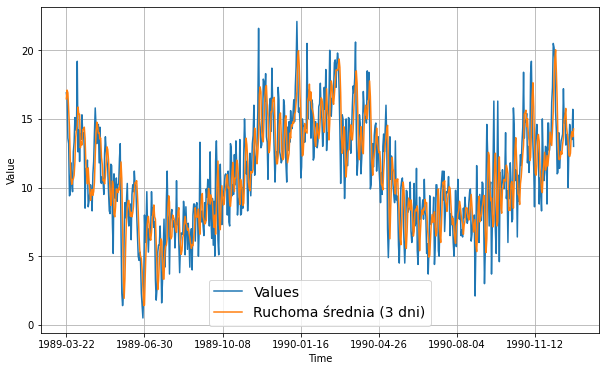

In [28]:
moving_avg = moving_average_forecast(values, 3)[split - 3:]

plt.figure(figsize=(10, 6))
plot_series(x_valid, y_valid, label="Values")
plot_series(x_valid, moving_avg, label="Ruchoma średnia (3 dni)")

In [29]:
print(keras.metrics.mean_absolute_error(y_valid, moving_avg).numpy())
print(keras.metrics.mean_squared_error(y_valid, moving_avg).numpy())

2.072205128205128
7.014871794871794


Szok! Osiągneliśmy gorsze wyniki niż w przypadku naiwnego podejścia. Może długość aplikowanego okna była za mała?
Spróbujmy dla innej wielkości okna.

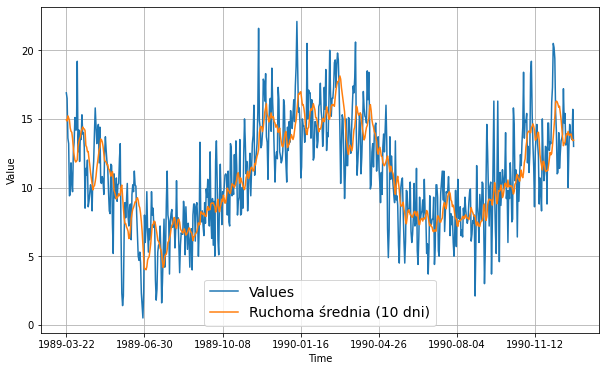

In [30]:
moving_avg = moving_average_forecast(values, 10)[split - 10:]

plt.figure(figsize=(10, 6))
plot_series(x_valid, y_valid, label="Values")
plot_series(x_valid, moving_avg, label="Ruchoma średnia (10 dni)")

In [31]:
print(keras.metrics.mean_absolute_error(y_valid, moving_avg).numpy())
print(keras.metrics.mean_squared_error(y_valid, moving_avg).numpy())

2.018692307692308
6.685355538461539


Wciąż gorsze wyniki. Powodem jest tutaj potężna wada tego podejścia, a mianowicie brak uwzględnienia sezonowości, która w przypadku temperatur jest oczywista i bardzo wyraźna

#Ulepszona metoda ruchomej średniej
Aby ulepszyć metodę ruchomej średniej należy zlikwidować jej wady - brak uwzględniania trendów oraz brak uwzględniania sezonowości.
W tym celu należy specjalnie zadaptować nasz zbiór danych. Zamiast korzystać po prostu z naszego zbioru, korzystać będziemy z różnic (wartość - wartość wcześniejsza o pewien czas t, np. 1 rok i różnica = czerwiec 1984 - czerwiec 1983 )

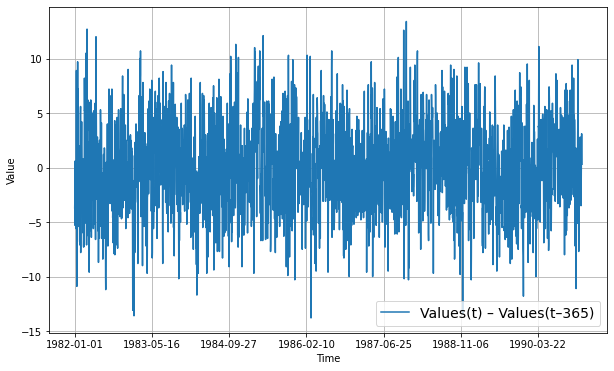

In [32]:
diff_values = (values[365:].reset_index() - values[:-365].reset_index())['Temp']
diff_time = time[365:]
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_values, label="Values(t) – Values(t–365)")
plt.show()

Podzbiór walidacyjny

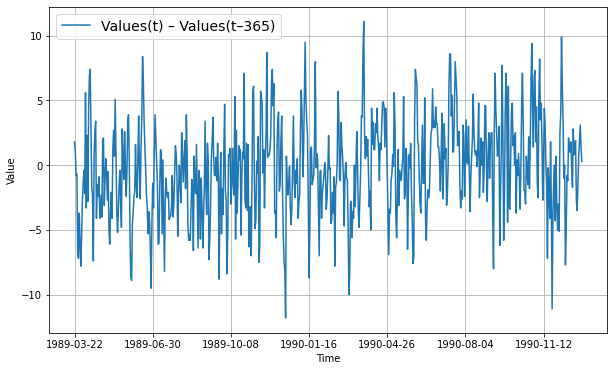

In [33]:
plt.figure(figsize=(10, 6))
plot_series(x_valid, diff_values[split - 365:], label="Values(t) – Values(t–365)")
plt.show()

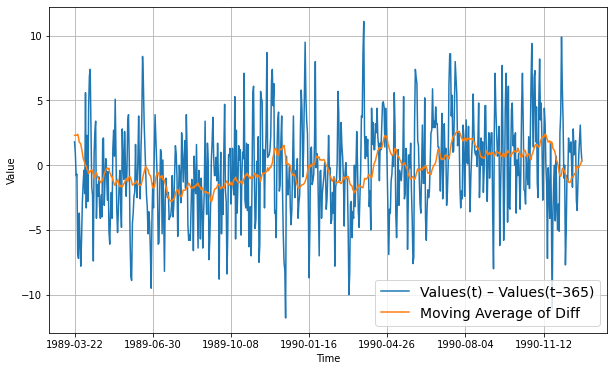

In [34]:
diff_moving_avg = moving_average_forecast(diff_values, 30)[split - 365 - 30:]

plt.figure(figsize=(10, 6))
plot_series(x_valid, diff_values[split - 365:], label="Values(t) – Values(t–365)")
plot_series(x_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

W porządku. Obliczyliśmy ruchomą średnią, ale nie jest to przecież nasz zbiór danych, a to on jest dla nas interesujący. W takim razie musimy go odzyskać.
Aby to zrobić należy dodać wartości z przeszłości.

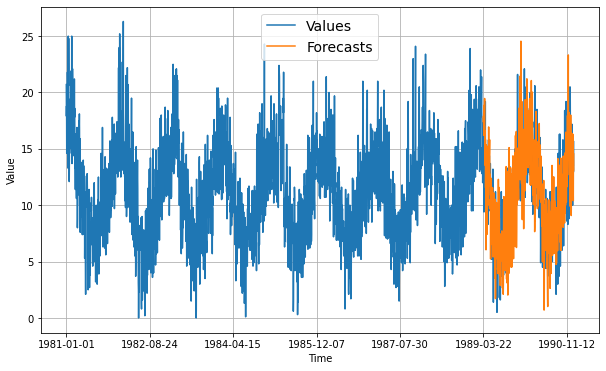

In [35]:
diff_moving_avg_plus_past = values[split - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time, values, label="Values")
plot_series(x_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [36]:
print(keras.metrics.mean_absolute_error(y_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_squared_error(y_valid, diff_moving_avg_plus_past).numpy())

2.902287179487179
13.794366256410257


Otrzymaliśmy tragiczne wyniki. Spróbujmy zredukować szum w początkowych danych.

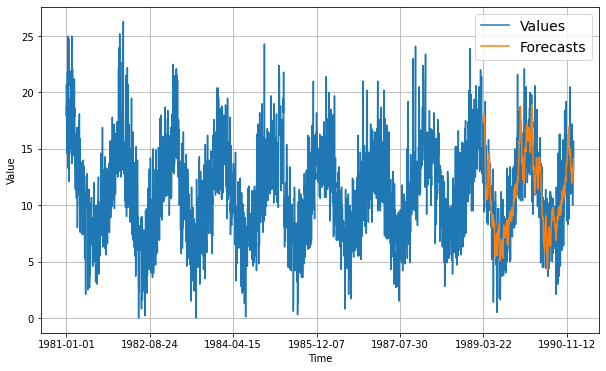

In [37]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(values[split - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time, values, label="Values")
plot_series(x_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [38]:
print(keras.metrics.mean_absolute_error(y_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_squared_error(y_valid, diff_moving_avg_plus_smooth_past).numpy())

2.197555244755245
8.117508752701847


Znacznie lepiej, jednakże wciąż otrzymaliśmy gorsze rezultaty niż w przypadku naiwnego przewidywania

#Przewidywanie - Machine Learning
Użyjemy metody regresji liniowej, w oparciu o okno zawierające 30 dni. Nasza początkowa sieć składać się będzie z pojedynczej warstwy, bez użycia funkcji aktywacji. Użycie pędu do optymalizacji wyników z reguły zwiększa zbieżność metody. 

In [39]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(y_train, window_size)
valid_set = window_dataset(y_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mse"])
model.fit(train_set, epochs=150, validation_data=valid_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
93/93 [==============================] - 4s 6ms/step - loss: 10.5815 - mae: 11.0703 - mse: 198.9177 - val_loss: 3.2128 - val_mae: 3.6826 - val_mse: 21.4497
Epoch 2/150
93/93 [==============================] - 1s 5ms/step - loss: 3.4293 - mae: 3.9021 - mse: 23.7409 - val_loss: 3.1437 - val_mae: 3.6189 - val_mse: 20.5599
Epoch 3/150
93/93 [==============================] - 1s 5ms/step - loss: 3.3775 - mae: 3.8503 - mse: 23.1184 - val_loss: 3.1043 - val_mae: 3.5795 - val_mse: 20.0941
Epoch 4/150
93/93 [==============================] - 1s 5ms/step - loss: 3.3397 - mae: 3.8131 - mse: 22.6082 - val_loss: 3.0599 - val_mae: 3.5347 - val_mse: 19.5889
Epoch 5/150
93/93 [==============================] - 1s 5ms/step - loss: 3.2896 - mae: 3.7615 - mse: 22.0088 - val_loss: 3.0161 - val_mae: 3.4877 - val_mse: 19.1123
Epoch 6/150
93/93 [==============================] - 1s 6ms/step - loss: 3.2473 - mae: 3.7184 - mse: 21.5153 - val_loss: 2.9749 - val_mae: 3.4476 - val_mse: 18.6413
Epoch 7

Sukces! Udało nam się przebić naiwne przewidywanie.
Możemy spróbować poprawić nasze wyniki na kilka sposobów. Po pierwsze, spróbujemy sprawdzić jaka stała ucząca może być dla nas najlepsza, poprzez zwiększanie jej co pewną ilość epok. Dzięki temu zobaczymy kiedy model uczy się najszybciej. 

In [40]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(y_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=120, callbacks=[lr_schedule])

Epoch 1/120


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


93/93 [==============================] - 1s 4ms/step - loss: 17.2072 - mae: 17.7067
Epoch 2/120
93/93 [==============================] - 0s 4ms/step - loss: 13.6792 - mae: 14.1782
Epoch 3/120
93/93 [==============================] - 0s 4ms/step - loss: 9.9460 - mae: 10.4424
Epoch 4/120
93/93 [==============================] - 0s 4ms/step - loss: 6.4463 - mae: 6.9359
Epoch 5/120
93/93 [==============================] - 0s 4ms/step - loss: 4.0545 - mae: 4.5317
Epoch 6/120
93/93 [==============================] - 0s 4ms/step - loss: 3.2058 - mae: 3.6785
Epoch 7/120
93/93 [==============================] - 0s 4ms/step - loss: 3.0546 - mae: 3.5238
Epoch 8/120
93/93 [==============================] - 0s 3ms/step - loss: 3.0308 - mae: 3.5004
Epoch 9/120
93/93 [==============================] - 0s 4ms/step - loss: 3.0227 - mae: 3.4922
Epoch 10/120
93/93 [==============================] - 0s 4ms/step - loss: 3.0147 - mae: 3.4835
Epoch 11/120
93/93 [==============================] - 0s 4ms/step 

(1e-06, 0.01, 0.0, 20.0)

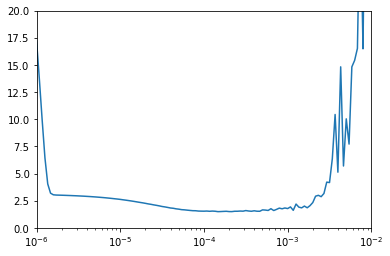

In [41]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-2, 0, 20])

Jak widać na wykresie, spadek błędu był najlepszy dla wartości ok 1e-4. Dla większych wartości błąd zaczął stawać się o wiele większy. Dzięki temu możemy założyć jaka stała będzie najlepsza dla naszego modelu. 
Następną rzeczą jaką możemy poprawić to dołożenie do modelu specjalnej metody wczesnego zatrzymania, która sprawdza czy błąd zmienił się na lepsze przez ostatnie kilka epok, jeśli nie to uczenie modelu zostaje przerwane wcześniej. Dzięki temu możemy ustawić ilośc epok na znacznie większą, np. 500 a model będzie się uczył dopóki błąd będzie malał. 

In [42]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(y_train, window_size)
valid_set = window_dataset(y_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mse"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
93/93 [==============================] - 1s 6ms/step - loss: 5.2676 - mae: 5.7455 - mse: 67.8318 - val_loss: 2.8977 - val_mae: 3.3667 - val_mse: 17.8169
Epoch 2/500
93/93 [==============================] - 1s 5ms/step - loss: 2.9686 - mae: 3.4376 - mse: 18.2840 - val_loss: 2.5707 - val_mae: 3.0339 - val_mse: 14.5484
Epoch 3/500
93/93 [==============================] - 1s 5ms/step - loss: 2.6310 - mae: 3.1000 - mse: 14.8504 - val_loss: 2.3430 - val_mae: 2.8054 - val_mse: 12.4634
Epoch 4/500
93/93 [==============================] - 1s 6ms/step - loss: 2.3866 - mae: 2.8509 - mse: 12.6321 - val_loss: 2.0282 - val_mae: 2.4854 - val_mse: 9.8647
Epoch 5/500
93/93 [==============================] - 1s 5ms/step - loss: 2.1496 - mae: 2.6087 - mse: 10.5869 - val_loss: 1.8185 - val_mae: 2.2682 - val_mse: 8.3052
Epoch 6/500
93/93 [==============================] - 1s 5ms/step - loss: 2.0125 - mae: 2.4741 - mse: 9.4902 - val_loss: 1.7700 - val_mae: 2.2248 - val_mse: 7.9460
Epoch 7/500
93

Następnie zdefiniujemy funkcję, która pozwoli nam stworzyć przewidywania dla danych na podstawie modelu. 

In [43]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [44]:
lin_forecast = model_forecast(model, values[split - window_size:-1], window_size)[:, 0]
lin_forecast.shape

(650,)

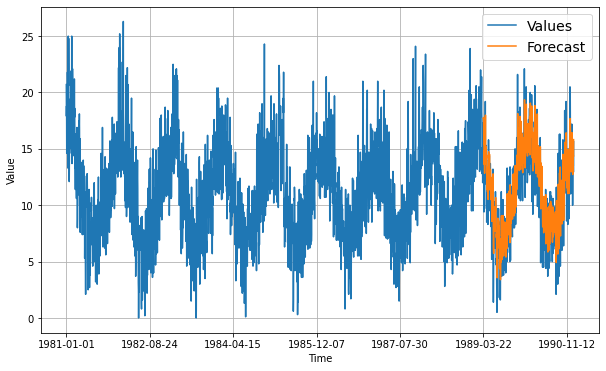

In [45]:
plt.figure(figsize=(10, 6))
plot_series(time, values, label="Values")
plot_series(x_valid, lin_forecast, label="Forecast")

In [46]:
print(keras.metrics.mean_absolute_error(y_valid, lin_forecast).numpy())
print(keras.metrics.mean_squared_error(y_valid, lin_forecast).numpy())

1.8384149
5.474232


Rezultat z dość znaczną poprawą. Spróbujmy jednak poprawić naszą sieć, poprzez dodanie kolejnych wartsw, wykorzystamy w tym celu warstwy Dense oraz dodamy do nich funkcję aktywacji relu. Na początku spróbujemy sprawdzić jaka stała ucząca najlepiej sprawdzi się dla naszych danych. 

In [47]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(y_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mse"])
history = model.fit(train_set, epochs=120, callbacks=[lr_schedule])

Epoch 1/120


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


93/93 [==============================] - 1s 4ms/step - loss: 10.7634 - mae: 11.2628 - mse: 146.4402
Epoch 2/120
93/93 [==============================] - 0s 4ms/step - loss: 10.3042 - mae: 10.8033 - mse: 135.5226
Epoch 3/120
93/93 [==============================] - 0s 4ms/step - loss: 9.7775 - mae: 10.2760 - mse: 123.4860
Epoch 4/120
93/93 [==============================] - 0s 4ms/step - loss: 9.1768 - mae: 9.6748 - mse: 110.4510
Epoch 5/120
93/93 [==============================] - 0s 4ms/step - loss: 8.4965 - mae: 8.9929 - mse: 96.6329
Epoch 6/120
93/93 [==============================] - 0s 4ms/step - loss: 7.7306 - mae: 8.2263 - mse: 82.2139
Epoch 7/120
93/93 [==============================] - 0s 4ms/step - loss: 6.8696 - mae: 7.3646 - mse: 67.5189
Epoch 8/120
93/93 [==============================] - 0s 4ms/step - loss: 5.9193 - mae: 6.4109 - mse: 52.9544
Epoch 9/120
93/93 [==============================] - 0s 4ms/step - loss: 4.9209 - mae: 5.4073 - mse: 39.5089
Epoch 10/120
93/93 [==

(1e-07, 0.01, 0.0, 30.0)

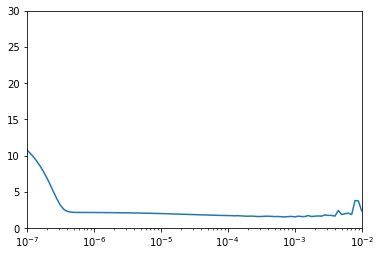

In [48]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-2, 0, 30])

In [49]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(y_train, window_size)
valid_set = window_dataset(y_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mse"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
93/93 [==============================] - 1s 6ms/step - loss: 2.6809 - mae: 3.1399 - mse: 17.6307 - val_loss: 1.7917 - val_mae: 2.2426 - val_mse: 8.3471
Epoch 2/500
93/93 [==============================] - 1s 5ms/step - loss: 1.9688 - mae: 2.4240 - mse: 9.5210 - val_loss: 1.7300 - val_mae: 2.1928 - val_mse: 7.8538
Epoch 3/500
93/93 [==============================] - 1s 5ms/step - loss: 1.8909 - mae: 2.3436 - mse: 8.9506 - val_loss: 1.6484 - val_mae: 2.0909 - val_mse: 7.3456
Epoch 4/500
93/93 [==============================] - 1s 5ms/step - loss: 1.8355 - mae: 2.2872 - mse: 8.4944 - val_loss: 1.5995 - val_mae: 2.0550 - val_mse: 6.9938
Epoch 5/500
93/93 [==============================] - 1s 5ms/step - loss: 1.8093 - mae: 2.2592 - mse: 8.2907 - val_loss: 1.5918 - val_mae: 2.0478 - val_mse: 6.9316
Epoch 6/500
93/93 [==============================] - 1s 5ms/step - loss: 1.7877 - mae: 2.2385 - mse: 8.1463 - val_loss: 1.5624 - val_mae: 2.0174 - val_mse: 6.7372
Epoch 7/500
93/93 [==

In [50]:
dense_forecast = model_forecast(
    model,
    values[split - window_size:-1],
    window_size)[:, 0]

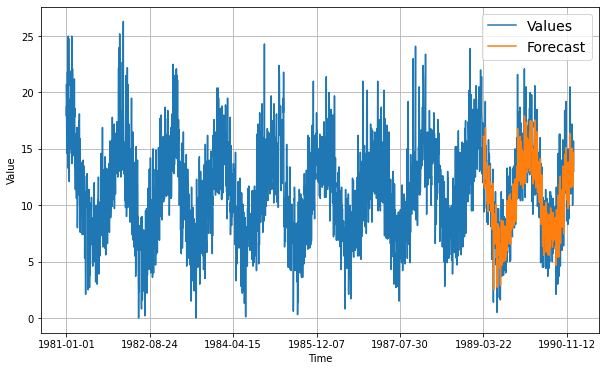

In [51]:
plt.figure(figsize=(10, 6))
plot_series(time, values, label="Values")
plot_series(x_valid, dense_forecast, label="Forecast")

In [52]:
print(keras.metrics.mean_absolute_error(y_valid, dense_forecast).numpy())
print(keras.metrics.mean_squared_error(y_valid, dense_forecast).numpy())

1.7710211
5.122745


Powinniśmy zaobserwować kolejną poprawę wyników. 


#RNN

In [53]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(y_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mse"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


24/24 [==============================] - 2s 45ms/step - loss: 37.8039 - mae: 38.3012 - mse: 2203.9795
Epoch 2/100
24/24 [==============================] - 1s 44ms/step - loss: 27.3641 - mae: 27.8591 - mse: 1234.3151
Epoch 3/100
24/24 [==============================] - 1s 44ms/step - loss: 18.6849 - mae: 19.1786 - mse: 629.0556
Epoch 4/100
24/24 [==============================] - 1s 45ms/step - loss: 14.1751 - mae: 14.6680 - mse: 388.1942
Epoch 5/100
24/24 [==============================] - 1s 42ms/step - loss: 12.1581 - mae: 12.6488 - mse: 296.5905
Epoch 6/100
24/24 [==============================] - 1s 42ms/step - loss: 10.7449 - mae: 11.2343 - mse: 240.5287
Epoch 7/100
24/24 [==============================] - 1s 43ms/step - loss: 9.5402 - mae: 10.0276 - mse: 199.3398
Epoch 8/100
24/24 [==============================] - 1s 46ms/step - loss: 8.5625 - mae: 9.0490 - mse: 168.2460
Epoch 9/100
24/24 [==============================] - 1s 43ms/step - loss: 7.7285 - mae: 8.2120 - mse: 144.052

(1e-07, 0.0001, 0.0, 30.0)

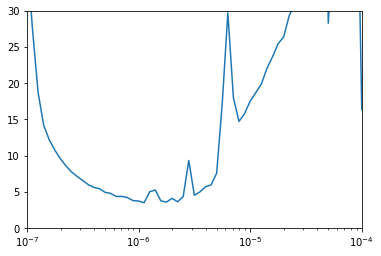

In [54]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [55]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(y_train, window_size, batch_size=128)
valid_set = window_dataset(y_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mse"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
24/24 [==============================] - 3s 62ms/step - loss: 50.3734 - mae: 50.8712 - mse: 4508.2480 - val_loss: 23.2949 - val_mae: 23.7940 - val_mse: 898.7714
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 2/500
24/24 [==============================] - 1s 48ms/step - loss: 12.1553 - mae: 12.6454 - mse: 366.5460 - val_loss: 6.7981 - val_mae: 7.2828 - val_mse: 120.8058
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 3/500
24/24 [==============================] - 1s 48ms/step - loss: 6.0353 - mae: 6.5127 - mse: 142.0536 - val_loss: 3.8748 - val_mae: 4.3456 - val_mse: 54.2864
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 4/500
24/24 [==============================] - 1s 47ms/step - loss: 4.7792 - mae: 5.2553 - mse: 86.8426 - val_loss: 5.2616 - val_mae: 5.7458 - val_mse: 58.3628
Epoch 5/500
24/24 [==============================] - 1s 47ms/step - loss: 4.7942 - mae: 5.2731 - mse: 73.3307 - val_loss: 3.8273 - val_mae: 4.2981 - val_mse

In [56]:
rnn_forecast = model_forecast(
    model,
    values[split - window_size:-1],
    window_size)[:, 0]

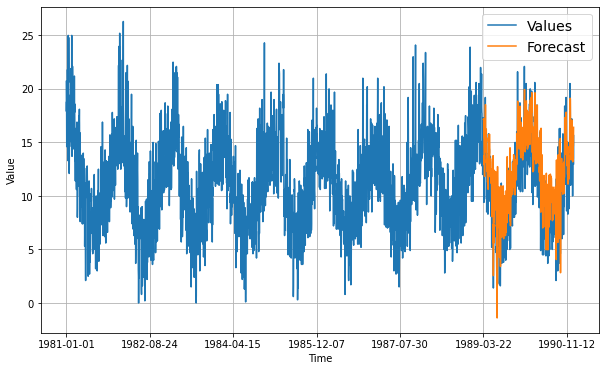

In [57]:
plt.figure(figsize=(10, 6))
plot_series(time, values, label="Values")
plot_series(x_valid, rnn_forecast, label="Forecast")

In [58]:
print(keras.metrics.mean_absolute_error(y_valid, rnn_forecast).numpy())
print(keras.metrics.mean_squared_error(y_valid, rnn_forecast).numpy())

2.1632266
7.434651


Zmienimy kształt okna zbioru danych, który zostanie użyty do uczenia sieci, tak aby każda z warstw RNN przekazywała do następnej warstwy wszystkie dane, co powinno przyspieszyc proces uczenia. 

In [59]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [60]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(y_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(y_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mse"])
early_stopping = keras.callbacks.EarlyStopping(patience=30)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
24/24 [==============================] - 3s 60ms/step - loss: 50.2005 - mae: 50.6981 - mse: 4456.5913 - val_loss: 25.8963 - val_mae: 26.3938 - val_mse: 1142.1544
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 2/500
24/24 [==============================] - 1s 55ms/step - loss: 16.7037 - mae: 17.1958 - mse: 650.4076 - val_loss: 11.3859 - val_mae: 11.8759 - val_mse: 294.2922
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 3/500
24/24 [==============================] - 1s 49ms/step - loss: 10.2508 - mae: 10.7366 - mse: 283.1075 - val_loss: 8.3322 - val_mae: 8.8170 - val_mse: 189.3493
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 4/500
24/24 [==============================] - 1s 47ms/step - loss: 7.8995 - mae: 8.3800 - mse: 190.3791 - val_loss: 6.5152 - val_mae: 6.9954 - val_mse: 121.2428
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 5/500
24/24 [==============================] - 1s 49ms/step - loss: 6.5220 - mae: 6.99

In [61]:
rnn_forecast = model_forecast(model,values[..., np.newaxis], window_size)[split - window_size:-1,-1,0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


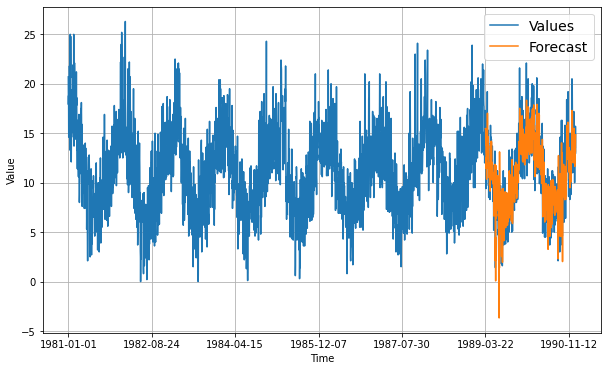

In [62]:
plt.figure(figsize=(10, 6))
plot_series(time, values, label="Values")
plot_series(x_valid, rnn_forecast, label="Forecast")

In [63]:
print(keras.metrics.mean_absolute_error(y_valid, rnn_forecast).numpy())
print(keras.metrics.mean_squared_error(y_valid, rnn_forecast).numpy())

1.805422
5.469539


#LSTRM RNN

In [73]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(y_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mse"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
99/99 [==============================] - 6s 7ms/step - loss: 54.2001 - mae: 54.7001 - mse: 3046.2939
Epoch 2/100
99/99 [==============================] - 1s 7ms/step - loss: 37.5629 - mae: 38.0629 - mse: 1499.0018
Epoch 3/100
99/99 [==============================] - 1s 7ms/step - loss: 18.7270 - mae: 19.2270 - mse: 419.9824
Epoch 4/100
99/99 [==============================] - 1s 6ms/step - loss: 3.5749 - mae: 4.0459 - mse: 28.3628
Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 2.4731 - mae: 2.9328 - mse: 14.5742
Epoch 6/100
99/99 [==============================] - 1s 7ms/step - loss: 2.4619 - mae: 2.9211 - mse: 14.4831
Epoch 7/100
99/99 [==============================] - 1s 6ms/step - loss: 2.4498 - mae: 2.9089 - mse: 14.3849
Epoch 8/100
99/99 [==============================] - 1s 7ms/step - loss: 2.4373 - mae: 2.8961 - mse: 14.2800
Epoch 9/100
99/99 [==============================] - 1s 7ms/step - loss: 2.4243 - mae: 2.8830 - mse: 14.1668
Epoch 10

(1e-08, 0.0001, 0.0, 30.0)

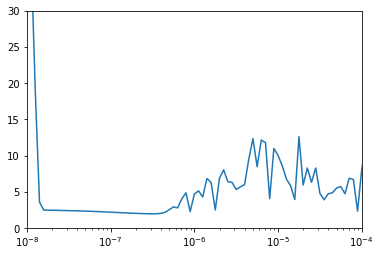

In [74]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [75]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(y_train, window_size)
valid_set = sequential_window_dataset(y_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
99/99 [==============================] - 3s 14ms/step - loss: 10.4667 - mae: 10.9478 - val_loss: 2.3391 - val_mae: 2.8030
Epoch 2/500
99/99 [==============================] - 1s 8ms/step - loss: 2.6336 - mae: 3.0965 - val_loss: 2.1402 - val_mae: 2.5959
Epoch 3/500
99/99 [==============================] - 1s 7ms/step - loss: 2.3681 - mae: 2.8287 - val_loss: 1.8935 - val_mae: 2.3463
Epoch 4/500
99/99 [==============================] - 1s 7ms/step - loss: 2.2934 - mae: 2.7526 - val_loss: 2.1886 - val_mae: 2.6481
Epoch 5/500
99/99 [==============================] - 1s 8ms/step - loss: 2.4359 - mae: 2.8981 - val_loss: 2.4937 - val_mae: 2.9589
Epoch 6/500
99/99 [==============================] - 1s 8ms/step - loss: 2.6837 - mae: 3.1483 - val_loss: 1.7318 - val_mae: 2.1827
Epoch 7/500
99/99 [==============================] - 1s 7ms/step - loss: 2.0258 - mae: 2.4812 - val_loss: 1.7801 - val_mae: 2.2237
Epoch 8/500
99/99 [==============================] - 1s 8ms/step - loss: 2.2767 

In [76]:
model = keras.models.load_model("my_checkpoint.h5")

In [77]:
rnn_forecast = model.predict(values[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split - 1:-1, 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


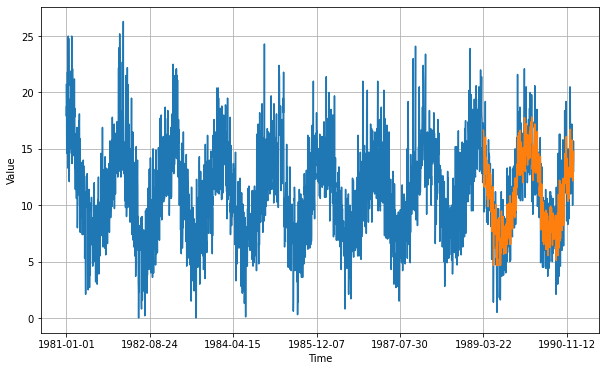

In [78]:
plt.figure(figsize=(10, 6))
plot_series(time, values)
plot_series(x_valid, rnn_forecast)

In [79]:
print(keras.metrics.mean_absolute_error(y_valid, rnn_forecast).numpy())
print(keras.metrics.mean_squared_error(y_valid, rnn_forecast).numpy())

1.7801232
5.230325


#CNN

Preprocessing

In [81]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(y_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mse"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
24/24 [==============================] - 29s 31ms/step - loss: 58.5985 - mae: 59.0985 - mse: 3747.8250
Epoch 2/100
24/24 [==============================] - 0s 12ms/step - loss: 57.2042 - mae: 57.7042 - mse: 3571.5996
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 55.4403 - mae: 55.9403 - mse: 3354.6377
Epoch 4/100
24/24 [==============================] - 0s 13ms/step - loss: 53.4545 - mae: 53.9545 - mse: 3118.8853
Epoch 5/100
24/24 [==============================] - 0s 13ms/step - loss: 51.2560 - mae: 51.7560 - mse: 2868.6216
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 48.8337 - mae: 49.3337 - mse: 2605.5132
Epoch 7/100
24/24 [==============================] - 0s 13ms/step - loss: 46.1551 - mae: 46.6550 - mse: 2329.8975
Epoch 8/100
24/24 [==============================] - 0s 13ms/step - loss: 43.1605 - mae: 43.6605 - mse: 2041.0486
Epoch 9/100
24/24 [==============================] - 0s 13ms/step - loss: 39.7506 - mae

(1e-08, 0.0001, 0.0, 30.0)

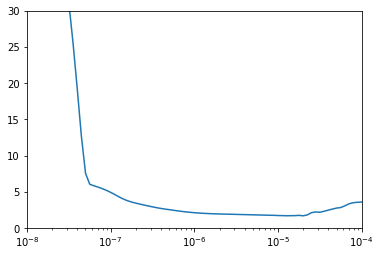

In [82]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [83]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(y_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(y_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mse"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_cnn.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
24/24 [==============================] - 3s 42ms/step - loss: 14.1387 - mae: 14.6307 - val_loss: 3.5864 - val_mae: 4.0587
Epoch 2/500
24/24 [==============================] - 0s 17ms/step - loss: 3.8257 - mae: 4.3010 - val_loss: 2.9177 - val_mae: 3.3896
Epoch 3/500
24/24 [==============================] - 0s 17ms/step - loss: 2.5991 - mae: 3.0637 - val_loss: 2.2376 - val_mae: 2.7025
Epoch 4/500
24/24 [==============================] - 0s 16ms/step - loss: 2.2198 - mae: 2.6785 - val_loss: 1.9915 - val_mae: 2.4466
Epoch 5/500
24/24 [==============================] - 0s 17ms/step - loss: 2.0410 - mae: 2.4964 - val_loss: 1.8676 - val_mae: 2.3192
Epoch 6/500
24/24 [==============================] - 0s 17ms/step - loss: 1.9335 - mae: 2.3869 - val_loss: 1.7904 - val_mae: 2.2404
Epoch 7/500
24/24 [==============================] - 0s 16ms/step - loss: 1.8690 - mae: 2.3210 - val_loss: 1.7480 - val_mae: 2.1961
Epoch 8/500
24/24 [==============================] - 1s 17ms/step - loss: 

In [84]:
model = keras.models.load_model("my_checkpoint_cnn.h5")

In [85]:
cnn_forecast = model_forecast(model, values[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split - window_size:-1, -1, 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


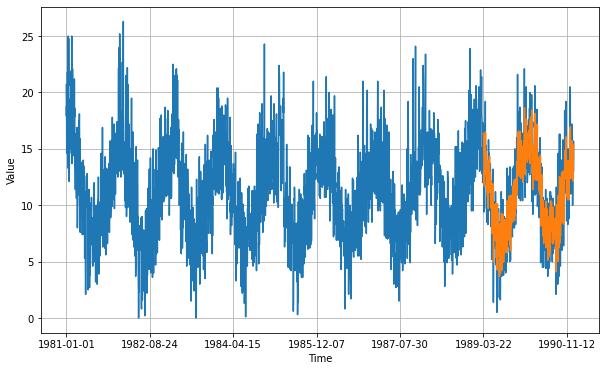

In [86]:
plt.figure(figsize=(10, 6))
plot_series(time, values)
plot_series(x_valid, cnn_forecast)

In [87]:
print(keras.metrics.mean_absolute_error(y_valid, cnn_forecast).numpy())
print(keras.metrics.mean_squared_error(y_valid, cnn_forecast).numpy())

1.7418631
4.990776
